In [1]:
#### Dependencies ####

import numpy as np
import logging
import sys
import time
import joblib
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM # Only necessary for feature extraction.

# Repository imports
from ridge_utils.ridge import bootstrap_ridge
import ridge_utils.npp
from ridge_utils.util import make_delayed
from ridge_utils.dsutils import make_word_ds
from ridge_utils.DataSequence import DataSequence
from ridge_utils.tokenization_helpers import generate_efficient_feat_dicts_opt
from ridge_utils.tokenization_helpers import convert_to_feature_mats_opt
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Some parameters
trim_start = 50 # Trim 50 TRs off the start of the story
trim_end = 5 # Trim 5 off the back
ndelays = 4 # We use 4 FIR delays (2 seconds, 4 seconds, 6 seconds, 8 seconds)
delays = range(1, ndelays + 1)

/n/home04/cfang/.conda/envs/sae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from configs import engram_dir, allstories
import os

box_dir = os.path.join(engram_dir, 'huth_box/')

# Load text data

In [4]:
box_dir = os.path.join(engram_dir, 'huth_box/')
grids = joblib.load(os.path.join(box_dir, "grids_huge.jbl")) # Load TextGrids containing story annotations
trfiles = joblib.load(os.path.join(box_dir, "trfiles_huge.jbl")) # Load TRFiles containing TR information

wordseqs = make_word_ds(grids, trfiles)
for story in wordseqs.keys():
    wordseqs[story].data = [i.strip() for i in wordseqs[story].data]
print("Loaded text data")
test_stories = ['wheretheressmoke']

Loaded text data


# Load LLM

In [5]:
from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch

from transformer_lens.utils import tokenize_and_concatenate
from huggingface_hub import login
from transformer_lens.components import TransformerBlock
from configs import huggingface_token

login(token=huggingface_token)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = HookedTransformer.from_pretrained("gemma-2-2b", device=device)
tokenizer = model.tokenizer
def override_to_local_attn(model, window_size=512):
    for b in model.blocks:  # Possibly a cleaner way by correctly using 'use_local_attn'
        if isinstance(b, TransformerBlock):
            n_ctx = b.attn.cfg.n_ctx
            attn_mask = torch.zeros((n_ctx, n_ctx)).bool()
            for i in range(n_ctx):
                start_idx = max(0, i-window_size)
                attn_mask[i, start_idx:i+1] = True
            b.attn.mask = attn_mask.to(device)

override_to_local_attn(model)
def find_word_boundaries(text_data, tokenizer):
    full_story = " ".join(text_data).strip()
    tokenized_story = tokenizer(full_story)['input_ids']

    word_boundaries = []  # In the tokenized story
    curr_word_idx = 0
    curr_word = text_data[curr_word_idx]
    curr_token_set = []

    if curr_word == '':
        curr_word_idx += 1
        curr_word = text_data[curr_word_idx]
        word_boundaries.append(1)

    for token_idx, token in enumerate(tokenized_story):
        curr_token_set.append(token)
        detokenized_chunk = tokenizer.decode(curr_token_set)
        if curr_word in detokenized_chunk:
            word_boundaries.append(token_idx)
            curr_word_idx += 1
            if curr_word_idx == len(text_data):
                break
            curr_word = text_data[curr_word_idx]
            curr_token_set = []

            if curr_word == '':  # Edge case
                word_boundaries.append(token_idx)
                curr_word_idx += 1
                if curr_word_idx == len(text_data):
                    break
                curr_word = text_data[curr_word_idx]

    return tokenized_story, word_boundaries

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model gemma-2-2b into HookedTransformer


In [6]:
llm_test_responses = []
for test_story in test_stories:
    ws = wordseqs[test_story]
    text_data = ws.data
    tokenized_story, word_boundaries = find_word_boundaries(text_data, tokenizer)
    with torch.no_grad():
        _, cache = model.run_with_cache(
            torch.tensor(tokenized_story).to(device),
            prepend_bos=True,
            names_filter=lambda name: name.startswith('blocks.7.hook_resid_post'),
        )
    llm_response = cache['blocks.7.hook_resid_post'][0, word_boundaries, :]
    llm_data_seq = DataSequence(llm_response.cpu().numpy(), ws.split_inds, ws.data_times, ws.tr_times)
    interp_llm_response = llm_data_seq.chunksums('lanczos', window=3)
    interp_llm_response = ridge_utils.npp.zs(interp_llm_response[10:-5])
    llm_test_responses.append(interp_llm_response[40:])

llm_test_responses = np.vstack(llm_test_responses)
print(llm_test_responses.shape)
del cache
torch.cuda.empty_cache()

(251, 2304)


In [7]:
X_test = make_delayed(llm_test_responses, delays)

# Load fMRI data

In [8]:
tensessions = joblib.load(os.path.join(box_dir, "stored_activations", "tensessions_wheretheressmoke_S03.jbl"))

# Get Model predictions

In [20]:
#np.random.seed(0)
#selected_features = np.random.choice(tensessions.shape[-1], size=5000, replace=False)
#np.random.seed()
import pickle
with open(os.path.join('pickles', 'voxel_indices', 'broca.pkl'), 'rb') as f:
    broca_voxel_indices = pickle.load(f)
selected_features = broca_voxel_indices

In [39]:
import pickle
with open(os.path.join('pickles', 'regression_weights', 'broca_gemma.pkl'), 'rb') as f:
    results = pickle.load(f)
    wt = results['regression_weights']
    best_estimator = results['best_estimator']


In [40]:
# Dot the weights with the features to get voxelwise model predictions
#pred = (wt @ X_test.T).T

X_test_scaled = best_estimator.named_steps['standardscaler'].transform(X_test)
pred = best_estimator.named_steps['ridge'].predict(X_test_scaled)

# Compare to fMRI data

In [41]:
_pred = pred
_tensessions = tensessions[:, 40:, selected_features]


In [42]:
def spe_and_cc_norm(orig_data, data_pred, data_norm=True, max_flooring=None):
    '''
    Computes the signal power explained and the cc_norm of a model given the observed and predicted values
    Assumes normalization unless data_norm is set to False
    
    orig_data: 3D numpy array (trials, timepoints, voxels)
    
    data_pred: 2D numpy array (timepoints, voxels)
    
    data_norm: bool -> Set to False if not pre-normalized
    
    max_flooring: None/float (0-1) -> If not None, compute cc_norm in an alternate way that floors cc_max by max_flooring.
    This is helpful to clean up bad voxels that are not at all language selective.
    
    According to Schoppe: https://www.frontiersin.org/articles/10.3389/fncom.2016.00010/full
    '''
    y = np.mean(orig_data, axis=0)
    num_trials = len(orig_data)
    if not data_norm:
        variance_across_time = np.var(orig_data, axis=1, ddof=1)
        TP = np.mean(variance_across_time, axis=0)
    else:
        TP = np.zeros(orig_data.shape[2]) + 1
    SP = (1 / (num_trials-1)) * ((num_trials * np.var(y, axis=0, ddof=1)) - TP) 
    SPE_num = (np.var(y, axis=0, ddof=1) - np.var(y - data_pred, axis=0, ddof=1)) 
    SPE = (np.var(y, axis=0, ddof=1) - np.var(y - data_pred, axis=0, ddof=1)) / SP
    y_flip = np.swapaxes(y, axis1=0, axis2=1)
    data_flip = np.swapaxes(data_pred, axis1=0, axis2=1)
    covs = np.zeros(y_flip.shape[0])
    for i, row in enumerate(y_flip):
        covs[i] = np.cov(y_flip[i], data_flip[i])[0][1]
    cc_norm =  np.sqrt(1/SP) * (covs / np.sqrt(np.var(data_pred, axis=0, ddof=1)))
    cc_max = None
    if max_flooring is not None:
        cc_max = np.nan_to_num(1 / (np.sqrt(1 + ((1/num_trials) * ((TP/SP)-1)))))
        #cc_max = np.maximum(cc_max, np.zeros(cc_max.shape) + max_flooring)
        corrs = np.zeros(y_flip.shape[0])
        for i, row in enumerate(y_flip):
            corrs[i] = np.corrcoef(y_flip[i], data_flip[i])[0][1]
        cc_norm = corrs / cc_max
    return SPE, cc_norm, cc_max, corrs


In [43]:

SPE, cc_norm, cc_max, corrs_unnorm = spe_and_cc_norm(_tensessions, _pred, max_flooring=0.25)



In [44]:
print(cc_norm)
print(cc_max)
print(corrs_unnorm)


[ 0.52306216  0.57816309  0.34997606  0.48494393  0.57933889  0.52554234
  0.61742228  0.53106598  0.61956196  0.51546583  0.22517957  0.38098772
  0.55239639  0.60992367  0.19449004  0.42044157  0.61146392  0.59042871
  0.5947591   0.54436478  0.45487273  0.39807882  0.5507219   0.5200393
  0.54715171  0.54521485  0.56516618  0.41968741  0.52250047  0.5722191
  0.26318055  0.40014231  0.57260393  0.49024049  0.12282     0.38958659
  0.45792718  0.63491117  0.72501937  0.40392629  0.17097398  0.3866783
  0.48944281  0.45758972  0.43159321  0.56535964  0.18325378  0.45233034
  0.49099377  0.29249715  0.64684436  0.52592798  0.42582982  0.57025656
  0.6902258   0.61833333  0.52692826  0.50375847  0.62345084  0.56979755
  0.54455661  0.4870111   0.35536884  0.52324193  0.1394122   0.18762186
  0.17328535  0.35409999  0.44505306 -0.0722541   0.29828569  0.549152
  0.5079588   0.61061848  0.4763922   0.49329106  0.5983255   0.55116793
  0.64001929  0.67788043  0.57026348  0.6032646   0.6814

In [45]:
cc_norm = np.array(cc_norm)

In [46]:
print((cc_norm == np.inf).sum())
print((cc_norm == -np.inf).sum())

0
0


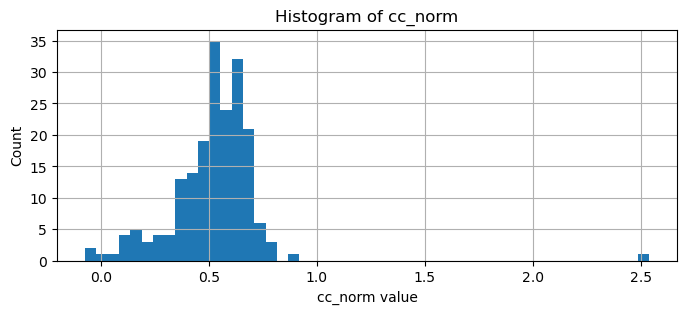

Mean cc_norm: 0.524
Median cc_norm: 0.547
Std cc_norm: 0.220


In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
cc_norm_finite = cc_norm[~np.isinf(cc_norm)]
plt.hist(cc_norm_finite, bins=50)
plt.title('Histogram of cc_norm')
plt.xlabel('cc_norm value')
plt.ylabel('Count')
plt.grid(True)
plt.show()

print(f"Mean cc_norm: {np.mean(cc_norm_finite):.3f}")
print(f"Median cc_norm: {np.median(cc_norm_finite):.3f}") 
print(f"Std cc_norm: {np.std(cc_norm_finite):.3f}")

In [48]:
print(np.mean(corrs_unnorm))
print(np.median(corrs_unnorm))
print(np.std(corrs_unnorm))
print(np.max(corrs_unnorm))
print(np.min(corrs_unnorm))


0.37021494686071754
0.39242892610562996
0.1540964407855528
0.6776736098853463
-0.017877495525880544
